# 06 Offices_Electric_Active Energy (kWh)

In [1]:
import pandas as pd

In [2]:
cd ..

c:\Users\Usuario\OneDrive\Documents\IE\3. Trimestre\Venture Lab & Capstone\Capstone\Tech side\vl_optimizer


## Definition of the constrain equation

**Offices_Electric_Active Energy = A⋅lightbulbs_active + B⋅active_wall_plugs + C⋅active_computers + D⋅active_printers + E⋅active_coffee_machines**

- **Offices_Electric_Active Energy** = Energy consumption of the Office building in a given period.

- **lightbulbs_active** = Represents the number of active lightbulbs during the specified period - Given.

- **active_wall_plugs** = Refers to the number of wall plugs currently in use or drawing power - Given.

- **active_computers** = Indicates the number of computers currently in use - Given.

- **active_printers** = The number of printers in active use during the measurement period - Controllable.

- **active_coffee_machines** = Represents the number of coffee machines currently in use - Controllable.

- **A,B,C,D,E** = Coefficients for each factor.

In [3]:
df = pd.read_csv('data/processed_data/industrial_sites_processed/2024-07-06T21-45-14_industrial_site2_processed.csv')

In [4]:
df.columns

Index(['Time', '02 Production_Electric_Active Energy (kWh)',
       '02 Production_Electric_Active Power (kW)',
       '02 Production_Electric_Apparent Power (kVa)',
       '02 Production_Electric_Power Factor (real)',
       '03 Chiller Group_Electric_Active Energy (kWh)',
       '03 Chiller Group_Electric_Active Power (kW)',
       '03 Chiller Group_Electric_Apparent Power (kVa)',
       '03 Chiller Group_Electric_Power Factor (real)',
       '04 UTA_Electric_Active Energy (kWh)',
       '04 UTA_Electric_Active Power (kW)',
       '04 UTA_Electric_Apparent Power (kVa)',
       '04 UTA_Electric_Power Factor (real)',
       '05 Compressors_Electric_Active Energy (kWh)',
       '05 Compressors_Electric_Active Power (kW)',
       '05 Compressors_Electric_Apparent Power (kVa)',
       '05 Compressors_Electric_Power Factor (real)',
       '06 Offices_Electric_Active Energy (kWh)',
       '06 Offices_Electric_Active Power (kW)',
       '06 Offices_Electric_Apparent Power (kVa)',
       '06 

In [5]:
office_target = (df['06 Offices_Electric_Active Energy (kWh)'])
office_target.to_csv('data/target_variables/target_office.csv', index=False)

## Other factors to include in the constrain equation

1. **lightbulbs_active**: The activity level of lightbulbs should scale with the lighting energy consumption, which could be a significant fraction of the total office energy use.
2. **active_wall_plugs**: The number of active wall plugs should correlate with the energy consumption from plugged devices.
3. **active_computers**: Computer use should scale with the proportion of energy dedicated to IT and office equipment.
4. **active_printers**: Printer usage should align with the specific energy consumption of these devices.
5. **active_coffee_machines**: The operation of coffee machines should scale with their share of energy use.

We will use the percentile distribution of energy consumption to dynamically adjust the maximum limits for variables, which are more directly influenced by the level of activity in the office.

Let’s start by analyzing the total energy consumption to inform these decisions.

Here are some key statistics from the total energy consumption data:

In [6]:
# Calculating statistical details for the total energy consumption data
production_stats = df['06 Offices_Electric_Active Energy (kWh)'].describe()
production_stats

count    8760.000000
mean        5.904957
std         3.615158
min         0.000000
25%         3.161875
50%         4.892134
75%         8.210000
max        18.058784
Name: 06 Offices_Electric_Active Energy (kWh), dtype: float64

Using these insights, let's redefine the boundaries for each variable:

1. **lightbulbs_active**:
   - **Minimum:** 0.00 kWh
   - **Maximum:** 5.42 kWh

2. **active_wall_plugs**:
   - **Minimum:** 0.00 kWh
   - **Maximum:** 7.22 kWh

3. **active_computers**:
   - **Minimum:** 0.00 kWh
   - **Maximum:** 3.61 kWh

4. **active_printers**:
   - **Minimum:** 0.00 kWh
   - **Maximum:**  kWh
0.90
5. **active_coffee_machines**:
   - **Minimum:** 0.00 kWh
   - **Maximum:** 0.36 kWh

For all variables, which should scale with energy consumption, we could set dynamic maximums based on the percentiles of energy consumption:

- Use the 75th percentile as a typical upper limit during high production times.
- Scale the maximum values of these variables proportionally to how close the energy consumption is to the maximum observed value.

## Synthesized dataset

In [9]:
import pandas as pd
import numpy as np

# Number of samples is equal to the number of entries in the consumption data
n_samples = len(office_target)

# Initialize the random seed for reproducibility
np.random.seed(42)

# Define dynamic ranges based on energy consumption percentiles
max_energy = df['06 Offices_Electric_Active Energy (kWh)'].max()
scale_factor = df['06 Offices_Electric_Active Energy (kWh)'] / max_energy

# Define a controlled noise level relative to the scale of each feature
noise_level = 0.15  # Noise level as a percentage of feature's max value

# Generating data within the defined boundaries
data = {
    'lightbulbs_active': np.maximum(0, 5.42 * scale_factor + np.random.normal(0, 5.42 * noise_level, n_samples)),
    'active_wall_plugs':np.maximum(0, 7.22 * scale_factor + np.random.normal(0, 7.22 * noise_level, n_samples)),
    'active_computers': np.maximum(0, 3.61 * scale_factor + np.random.normal(0, 3.61 * noise_level, n_samples)),
    'active_printers': np.maximum(0, 0.90 * scale_factor + np.random.normal(0, 0.90 * noise_level, n_samples)),
    'active_coffee_machines': np.maximum(0, 0.36 * scale_factor + np.random.normal(0, 0.36 * noise_level, n_samples))
}

df_simulated = pd.DataFrame(data)

# Save the generated data to a new CSV
output_path = 'data/synthesized_data/office_synthesized.csv'
df_simulated.to_csv(output_path, index=False)

output_path

'data/synthesized_data/office_synthesized.csv'

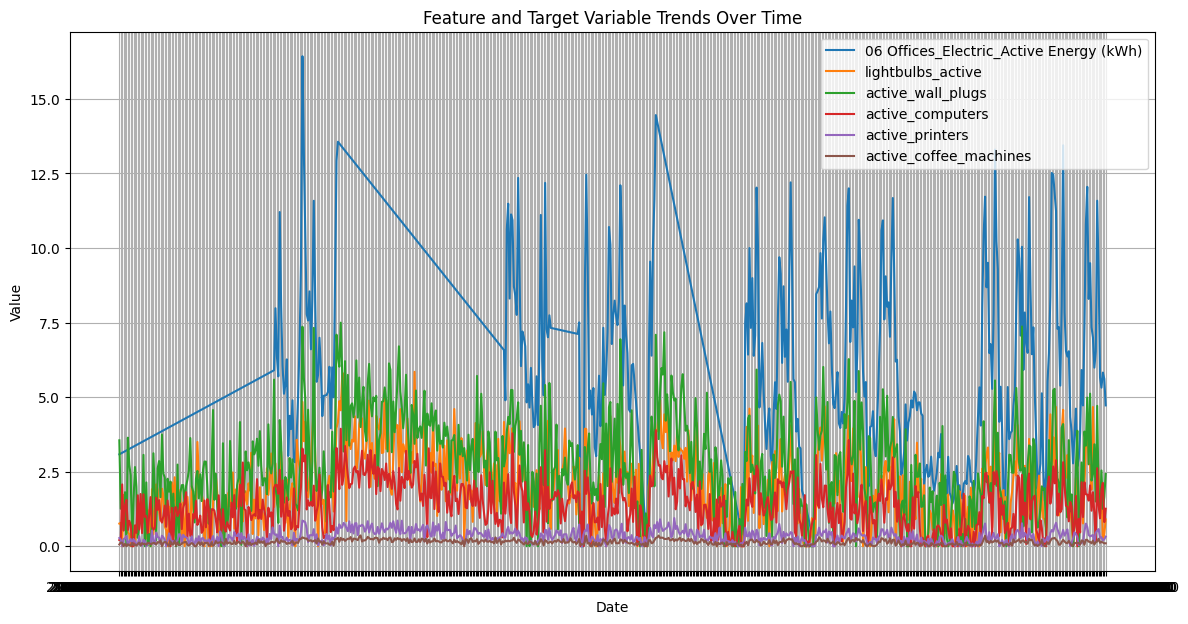

In [10]:
import matplotlib.pyplot as plt

# Combine target and features into one DataFrame
df_combined = pd.concat([df['Time'], df['06 Offices_Electric_Active Energy (kWh)'], df_simulated], axis=1)
df_combined.set_index('Time', inplace=True)

# Define the time period you want to plot
start_date = '2023-06-01'
end_date = '2023-06-30'

# Slice the DataFrame to the desired period
df_period = df_combined.loc[start_date:end_date]

# Plotting
plt.figure(figsize=(14, 7))
for column in df_period.columns:
    plt.plot(df_period.index, df_period[column], label=column)
plt.legend()
plt.title('Feature and Target Variable Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()


## Get cofficients

In [11]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump

# Define the target
target = office_target

# Define the features
features = df_simulated.columns

# Split the data into features (X) and target (y)
X = df_simulated
y = target

# Initialize the linear regression model
model = LinearRegression()

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results_mse = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
cv_results_r2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# Fit the model on the entire dataset
model.fit(X, y)

# Get the intercept and coefficients
intercept = model.intercept_
coefficients = model.coef_

# Save the trained model to a file
model_params = {
    'intercept': intercept,
    'coefficients': coefficients,
    'features': features
}
model_filename = 'equation_modeling/models/office_consumption_model.joblib'
dump(model_params, model_filename)

# Calculate and print performance metrics
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error (Cross-Validation): {-cv_results_mse.mean()}')
print(f'Standard Deviation (Cross-Validation): {cv_results_mse.std()}')
print(f'R^2 Score (Cross-Validation): {cv_results_r2.mean()}')
print(f'Overall R^2 Score: {r2}')

# Optional: Print the coefficients of the model
coefficients_df = pd.DataFrame(coefficients, features, columns=['Coefficient'])
print(f'Intercept: {intercept}')
print(coefficients_df)


Mean Squared Error (Cross-Validation): 1.277939958175431
Standard Deviation (Cross-Validation): 0.046029413806609486
R^2 Score (Cross-Validation): 0.902095097226141
Overall R^2 Score: 0.9023330893490779
Intercept: 0.26039035147439904
                        Coefficient
lightbulbs_active          0.608375
active_wall_plugs          0.480035
active_computers           0.974240
active_printers            3.604773
active_coffee_machines     9.465781
